In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

# Load the dataset
num = 5016
file_path = 'Female/TagData/LowTag' + str(num) + '.csv'
deer_data = pd.read_csv(file_path)

# load the covariate .tif file
covariate_file_path = 'Female/NLCDClip/LowTag' + str(num) + 'NLCDclip.tif'
covariate_file = rasterio.open(covariate_file_path)


In [49]:
row, col = covariate_file.index(deer_data['X'], deer_data['Y'])
# Assuming row and col are lists of the same length
values = []
roi = covariate_file.read(1)
for r, c in zip(row, col):
    if r < roi.shape[0] and c < roi.shape[1]:
        values.append(covariate_file.read(1)[r, c])
    else:
        values.append(None)

deer_data['covariate'] = values
deer_data.head()

,jul,X,Y,covariate
0,65.250544,239089.133481,4.764405e+06,41.0
1,65.417211,238560.253653,4.764645e+06,41.0
2,65.583970,239160.841604,4.764616e+06,41.0
3,65.750556,239244.131367,4.764592e+06,41.0
4,65.917002,239233.762769,4.764610e+06,41.0


In [50]:
# X_min = deer_data['X'].min()
# Y_min = deer_data['Y'].min()
# deer_data['X']  = deer_data['X'] - X_min
# deer_data['Y']  = deer_data['Y'] - Y_min

X_mean = deer_data['X'].mean()
Y_mean = deer_data['Y'].mean()
X_std = deer_data['X'].std()
Y_std = deer_data['Y'].std()

deer_data['X']  = (deer_data['X'] - X_mean) / X_std
deer_data['Y']  = (deer_data['Y'] - Y_mean) / Y_std


In [51]:
start_time, end_time = deer_data['jul'].min(), deer_data['jul'].max()
time_interval = 0.16
tolerance = 0.08

In [52]:
T_values = np.arange(start_time, end_time, time_interval)
df = pd.DataFrame(T_values, columns=['T'])

In [53]:
# Function to find nearest row within tolerance
def find_nearest_row_within_tolerance(value, tolerance, dataframe, column_name):
    nearest_idx = (dataframe[column_name] - value).abs().argsort()[:1]
    nearest_value = dataframe[column_name].iloc[nearest_idx].values[0]
    if abs(nearest_value - value) <= tolerance:
        return dataframe.iloc[nearest_idx]
    return pd.DataFrame(columns=dataframe.columns)


# Initialize a list to store dictionaries
data_list = []

# Merge data
for t_value in df['T']:
    matched_row = find_nearest_row_within_tolerance(t_value, tolerance, deer_data, 'jul')
    if not matched_row.empty:
        row_data = {'T': t_value, **matched_row.iloc[0].to_dict()}
    else:
        row_data = {'T': t_value, **{col: np.nan for col in deer_data.columns}}
    data_list.append(row_data)

# Create DataFrame from list of dictionaries
df_matched = pd.DataFrame(data_list)

In [28]:
df_matched.to_csv('Female/Processed/LowTag' + str(num) + '.csv', index=False)

In [54]:
df_matched

,T,jul,X,Y,covariate
0,65.250544,65.250544,0.161881,-0.160413,41.0
1,65.410544,65.417211,-0.924868,0.346857,41.0
2,65.570544,65.583970,0.309228,0.286495,41.0
3,65.730544,65.750556,0.480373,0.235765,41.0
4,65.890544,65.917002,0.459067,0.273818,41.0
...,...,...,...,...,...
9642,1607.970544,1607.917454,2.493539,0.497618,41.0
9643,1608.130544,1608.084016,2.481223,0.284093,41.0
9644,1608.290544,1608.250382,2.470699,0.279285,41.0
9645,1608.450544,1608.417431,2.331058,0.399856,41.0


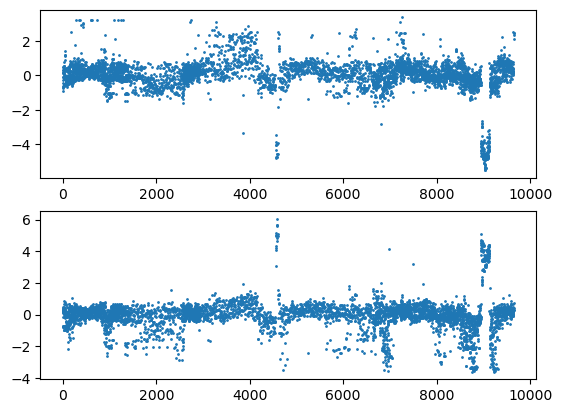

In [55]:
fig, axs = plt.subplots(2)
axs[0].plot(df_matched['X'], 'o', markersize=1)
axs[1].plot(df_matched['Y'], 'o', markersize=1)